In [1]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
#import plotly.express as px
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [2]:
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_21508\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_21508\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_21508\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [3]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [4]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [5]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)

In [6]:
data = data.dropna()

In [36]:
#energies = ['biomass', 'hard_coal', 'oil', 'geothermal', 'other', 'solar', 'waste',
#       'wind','total_aggregated', 'hydro_tot', 'gas_tot']

# 24h ARIMA

In [25]:
n_train = 35064
n_test = int(len(data)-n_train)

In [27]:
def arima_data_generator(data, feature):
    series = data['total_aggregated'].values
    train_array, test_array = series[:n_train], series[n_train:]
    # Replace NaN values with the mean of the series
    train_array[np.isnan(train_array)] = np.mean(train_array)
    test_array[np.isnan(test_array)] = np.mean(test_array)

        #train_df, test_df = pd.DataFrame(train_array), pd.DataFrame(test_array)

    return train_array, test_array

train, test = arima_data_generator(data, 'total_aggregated')


In [28]:
series = data['total_aggregated'].values
scaler1 = MinMaxScaler()
scaler2 = StandardScaler()
#scaler.fit(series[:n_train].reshape(-1,1))
## Transfom on both Training and Test data
#scaled_series = scaler.transform(series.reshape(-1, 1))

Test RMSE for AR(1): 6522.842


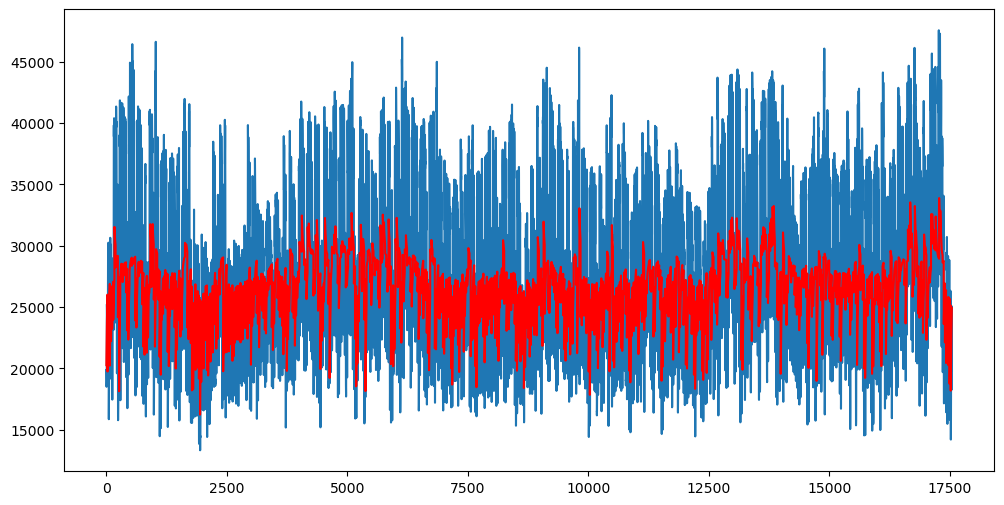

In [35]:
# train autoregression
ar_orders = [1] # IMPOSTO L'ORDINE DELL'AR
for order in ar_orders:
    history = [x for x in train] # IMPOSTO LA WINDOW DI 3 ANNI DEL TRAINING SET
    predictions = [] # LISTA DEI FORECAST
    n_forecast_steps = 24 # NUMERO DI STEP AHEAD DA PREVEDERE
    for i in range(0, len(test), n_forecast_steps): # STESSO PROCEDIMENTO DELLE RETI NEURALI IN CUI SELEZIONO GLI INDICI DELLE 24 OSSERVAZIONI DA PREVEDERE
        t_end = i + n_forecast_steps
        if t_end > len(test):
            t_end = len(test)
        test_block = test[i:t_end]
        model = ARIMA(history, order=(1,0,0))
        model_fit = model.fit()
        output = model_fit.forecast(steps=len(test_block))
        yhat = output
        if isinstance(yhat, (int, float)):
            yhat = [yhat]
        predictions.extend(yhat)
        obs = test_block
        history.extend(obs)
        history = history[24:]
        #for z in zip(yhat, obs):
        #    print('predicted=%s, expected=%s' % z)
    rmse = sqrt(mean_squared_error(test, predictions))
    print(f'Test RMSE for AR({order}): %.3f' % rmse)
    # plot
    pyplot.figure(figsize=(12,6))
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()

# WE DUMMIES

In [11]:

def sarimax_data_generator(data, feature, exog_features):
    series = data['total_aggregated'].values
    exog_data = data[exog_features].values
    train_array, test_array = series[:n_train], series[n_train:]
    train_exog, test_exog = exog_data[:n_train], exog_data[n_train:]
    # Replace NaN values with the mean of the train series
    train_array[np.isnan(train_array)] = np.mean(train_array)
    train_exog[np.isnan(train_exog)] = np.mean(train_exog)

    return train_array, test_array, train_exog, test_exog

train, test, train_exog, test_exog = sarimax_data_generator(data, 'total_aggregated', ['saturday', 'sunday'])

In [12]:
series = data['total_aggregated'].values
exog1 = data['saturday'].values
exog2 = data['sunday'].values

train_array, test_array = series[:n_train], series[n_train:]

target_scaler = MinMaxScaler()
train_scaled = target_scaler.fit_transform(train_array.reshape(-1,1))
test_scaled = target_scaler.transform(test_array.reshape(-1,1))

exog1_s = target_scaler.transform(exog1.reshape(-1,1))
exog2_s = target_scaler.transform(exog2.reshape(-1,1))

train_exog1, test_exog1 = exog1_s[:n_train], exog1_s[n_train:]
train_exog2, test_exog2 = exog2_s[:n_train], exog2_s[n_train:]

train_exog = np.concatenate((np.array(train_exog1).reshape(-1,1), np.array(train_exog2).reshape(-1,1)), axis = 1)
test_exog = np.concatenate((np.array(test_exog1).reshape(-1,1), np.array(test_exog2).reshape(-1,1)), axis = 1)

In [ ]:
#    return train_array, test_array, train_exog, test_exog
#train, test, train_exog, test_exog = sarimax_data_generator(data, 'total_aggregated', 'business hour')

Optimization terminated successfully.
         Current function value: -1.428817
         Iterations: 200
         Function evaluations: 363
Optimization terminated successfully.
         Current function value: -1.429212
         Iterations: 208
         Function evaluations: 371
Optimization terminated successfully.
         Current function value: -1.430745
         Iterations: 191
         Function evaluations: 348
Optimization terminated successfully.
         Current function value: -1.432187
         Iterations: 228
         Function evaluations: 400
Optimization terminated successfully.
         Current function value: -1.433382
         Iterations: 206
         Function evaluations: 367
Optimization terminated successfully.
         Current function value: -1.433424
         Iterations: 221
         Function evaluations: 394
Optimization terminated successfully.
         Current function value: -1.433536
         Iterations: 211
         Function evaluations: 374
Optimization 

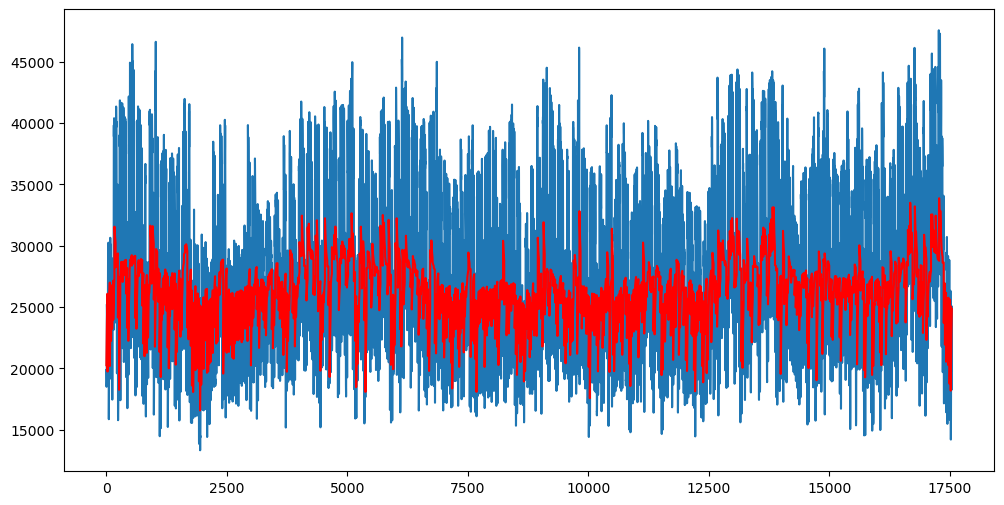

In [16]:
ar_orders = [1]
for order in ar_orders:
    history = [x for x in train_scaled]
    exog_history = [x for x in train_exog]
    predictions = list()
    window_size = 24
    for i in range(0, len(test_scaled), window_size):
        t_end = i + 24
        if t_end > len(test_scaled):
            t_end = len(test_scaled)
        test_block = test_scaled[i:t_end]
        exog_block = test_exog[i:t_end]
        model = SARIMAX(history, exog=exog_history, 
                        order=(order,0,0), seasonal_order=(0,0,0,24))
        model_fit = model.fit(method='nm',maxiter=500)
        output = model_fit.forecast(steps=len(test_block), exog=exog_block)
        yhat = output
        if isinstance(yhat, (int, float)):
            yhat = [yhat]
        predictions.extend(yhat)
        obs = test_block
        exog_obs = exog_block
        history.extend(obs)
        history = history[24:]
        exog_history.extend(exog_obs)
        exog_history = exog_history[24:]
        #for z in zip(yhat, obs):
        #    print('predicted=%s, expected=%s' % z)
    y_preds = target_scaler.inverse_transform(np.array(predictions).reshape(-1,1))
    #series = data['total_aggregated'].values
    truth = series[-len(test):]
    rmse = sqrt(mean_squared_error(truth, y_preds))
    print('Test RMSE: %.3f' % rmse)
    # plot
    pyplot.figure(figsize=(12,6))
    pyplot.plot(test)
    pyplot.plot(y_preds, color='red')
    pyplot.show()

# BH DUMMY

In [17]:
exog3 = data['business hour'].values

exog3_s = target_scaler.transform(exog3.reshape(-1,1))

train_exog3, test_exog3 = exog3_s[:n_train], exog3_s[n_train:]

Test RMSE: 6523.513


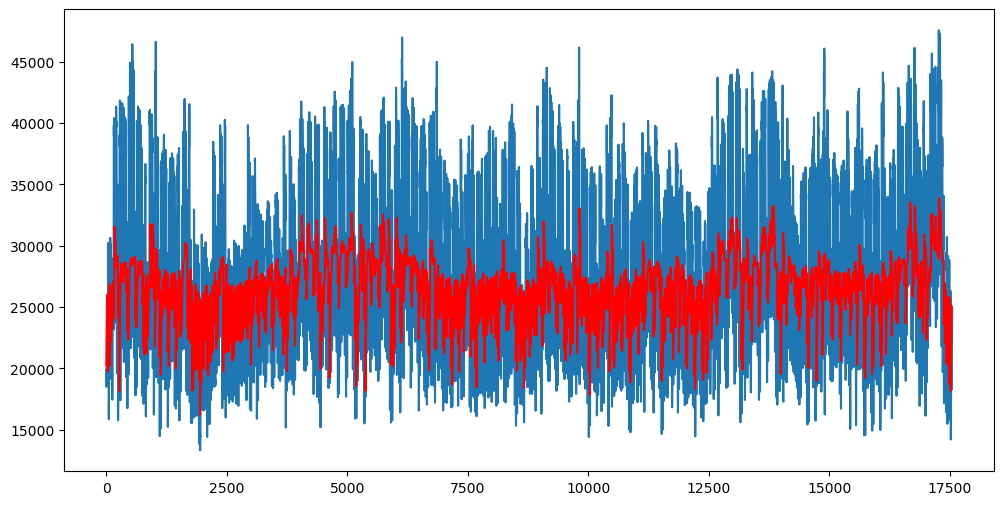

In [19]:
ar_orders = [1]
for order in ar_orders:
    history = [x for x in train]
    exog_history = [x for x in train_exog3]
    predictions = list()
    window_size = 24
    for i in range(0, len(test), window_size):
        t_end = i + 24
        if t_end > len(test):
            t_end = len(test)
        test_block = test[i:t_end]
        exog_block = test_exog3[i:t_end]
        model = SARIMAX(history, exog=exog_history, 
                        order=(order,0,0), seasonal_order=(0,0,0,24))
        model_fit = model.fit()
        output = model_fit.forecast(steps=len(test_block), exog=exog_block)
        yhat = output
        if isinstance(yhat, (int, float)):
            yhat = [yhat]
        predictions.extend(yhat)
        obs = test_block
        exog_obs = exog_block
        history.extend(obs)
        history = history[24:]
        exog_history.extend(exog_obs)
        exog_history = exog_history[24:]
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot
    pyplot.figure(figsize=(12,6))
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()